In [2]:
tankbind_src_folder_path = "./tankbind/"
import sys
sys.path.insert(0, tankbind_src_folder_path)

In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [4]:
df = pd.read_csv('Mcule_10000.csv', index_col=0)

In [5]:
from feature_utils import get_protein_feature, get_clean_res_list
from Bio.PDB import PDBParser

In [6]:
def extract_protein_names(file_path):
    protein_names = []
    with open(file_path, 'r') as file:
        for line in file:
            # Get the base name without directory path
            base_name = os.path.basename(line.strip())
            # Split the base name to get the protein name without extension
            protein_name = os.path.splitext(base_name)[0]
            protein_names.append(protein_name)
    return protein_names

file_path = 'pdb_dataset.ds'
protein_names = extract_protein_names(file_path)
print(protein_names[0:5])

['1A07', '1A08', '1A09', '1A0N', '1A1A']


In [7]:
protein_names.__len__()

5963

In [8]:
import random
n = len(protein_names) // 5
sampled_protein_names = random.sample(protein_names, n)
print(sampled_protein_names[0:15], len(sampled_protein_names))

['3ZXZ', '1O4O', '1PYX', '2CGX', '4TT7', '1FIN', '4BCH', '6KC4', '7BJE', '8DQT', '6ZH6', '6FYI', '5UGC', '4EAJ', '7P6N'] 1192


In [9]:
def process_proteins(protein_names, pdb_directory):
    parser = PDBParser(QUIET=True)
    protein_dict = {}
    i = 0
    for proteinName in protein_names:
        try:
            # print(i, ': ', proteinName)
            proteinFile = f"{pdb_directory}/{proteinName}.pdb"
            s = parser.get_structure(proteinName, proteinFile)
            res_list = list(s.get_residues())
            clean_res_list = get_clean_res_list(res_list, ensure_ca_exist=True)
            protein_dict[proteinName] = get_protein_feature(clean_res_list)
        except Exception as e:
            print(f"Error processing {proteinName}: {e}")
        finally:
            i += 1
    
    return protein_dict

pdb_directory = "PDB_files"  # Directory containing PDB files

protein_dict = process_proteins(sampled_protein_names, pdb_directory)

In [10]:

protein_dict.keys().__len__() # doesn't work for 2 proteins 1IAN & 6XR4 (indexError: Dimension out of range (expected to be in range of [-1, 0], but got 1)) --> Cause: likely different format of PDB file

1192

In [11]:
import torch
torch.save(protein_dict, 'precalculated_protein_features_small.pt')

In [12]:
protein_names_new = list(protein_dict.keys())
protein_names_new.__len__()

1192

In [13]:
info = []
for protein_name in protein_names_new:
    for i, line in tqdm(df.iterrows(), total=len(df)):
        smiles = line['smiles']
        compund_name = ''
        protein_name = protein_name
        com = ",".join([str(x.round(3)) for x in protein_dict[protein_name][0].mean(axis=0).numpy()])
        info.append([protein_name, compund_name, smiles, "protein_center", com])

info = pd.DataFrame(info, columns=['protein_name', 'compound_name', 'smiles', 'pocket_name', 'pocket_com'])


  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [00:01<00:00, 7463.09it/s]


In [14]:
info.head()
info.__len__()


11920000

In [15]:
info

,protein_name,compound_name,smiles,pocket_name,pocket_com
0,3ZXZ,,CC1=C(C2=CC=C(F)C=C2)N=C(NC(C2=C(C)C3=C(CCCC3=...,protein_center,"15.481,78.55,10.586"
1,3ZXZ,,CC(N(C(NC1C2OC(CC2)C1)=O)C)CS(C)(=O)=O,protein_center,"15.481,78.55,10.586"
2,3ZXZ,,S(=O)(=O)(C1C=CC2=C(C=1)N=C(N2C1CCCC1)C)N1CCC(...,protein_center,"15.481,78.55,10.586"
3,3ZXZ,,N1CCCCC1CC1=CC=NC=C1,protein_center,"15.481,78.55,10.586"
4,3ZXZ,,N1(CCC2C=CC(CNC(=O)NC3=CC=CC=C3C)=CC1=2)C(C1=C...,protein_center,"15.481,78.55,10.586"
...,...,...,...,...,...
11919995,6HMC,,CCCN(C(OC(C)(C)C)=O)CCNC(C1=C(SC)C=CC=C1)=O,protein_center,"0.283,-0.958,-0.018"
11919996,6HMC,,N[C@H](C1C=NC=CC=1Br)C(F)(F)F,protein_center,"0.283,-0.958,-0.018"
11919997,6HMC,,C12N=CN(C(=O)C=1N=NN2CC1C=CC(=CC=1)F)CC(=O)NC1...,protein_center,"0.283,-0.958,-0.018"
11919998,6HMC,,N1(CCC[C@H](O)[C@@H]1CC1=CC=CC=C1F)CC1C=CC=CC=...,protein_center,"0.283,-0.958,-0.018"


### Construct the Dataset

In [6]:
import torch
torch.set_num_threads(1)

In [7]:
from torch_geometric.data import Dataset
from utils import construct_data_from_graph_gvp
import rdkit.Chem as Chem    # conda install rdkit -c rdkit if import failure.
from feature_utils import extract_torchdrug_feature_from_mol, get_canonical_smiles

In [104]:
class MyDataset_VS(Dataset):
    def __init__(self, root, data=None, protein_dict=None, precomputed_mol_dict=None, proteinMode=0, compoundMode=1,
                 pocket_radius=20, shake_nodes=None,
                 transform=None, pre_transform=None, pre_filter=None):
        self.data = data
        self.protein_dict = protein_dict
        self.precomputed_mol_dict = precomputed_mol_dict
        super().__init__(root, transform, pre_transform, pre_filter)
        self.data = torch.load(self.processed_paths[0])
        self.protein_dict = torch.load(self.processed_paths[1])
        self.precomputed_mol_dict = torch.load(self.processed_paths[2])
        self.proteinMode = proteinMode
        self.pocket_radius = pocket_radius
        self.compoundMode = compoundMode
        self.shake_nodes = shake_nodes

    @property
    def processed_file_names(self):
        return ['data.pt', 'proteins.pt', 'molecules.pt']

    def process(self):
        # Save data and protein dictionary
        torch.save(self.data, self.processed_paths[0])
        torch.save(self.protein_dict, self.processed_paths[1])
        torch.save(self.precomputed_mol_dict, self.processed_paths[2])

    def len(self):
        return len(self.data)

    def get(self, idx):
        line = self.data.iloc[idx]
        smiles = line['smiles']
        pocket_com = line['pocket_com']
        pocket_com = np.array(pocket_com.split(",")).astype(float) if isinstance(pocket_com, str) else pocket_com
        pocket_com = pocket_com.reshape((1, 3))
        use_whole_protein = line.get('use_whole_protein', False)

        protein_name = line['protein_name']
        protein_data = self.protein_dict.get(protein_name)
        
        if protein_data is None:
            raise ValueError(f"Protein {protein_name} not found in pre-calculated protein dictionary")

        protein_node_xyz, protein_seq, protein_node_s, protein_node_v, protein_edge_index, protein_edge_s, protein_edge_v = protein_data

        # Load precomputed molecular features
        molecule_data = self.precomputed_mol_dict.get(smiles)
        if molecule_data is None:
            raise ValueError(f"SMILES {smiles} not found in precomputed molecular dictionary")
        
        coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list, pair_dis_distribution = self.precomputed_mol_dict[smiles]

        data, input_node_list, keepNode = construct_data_from_graph_gvp(
            protein_node_xyz, protein_seq, protein_node_s, protein_node_v, 
            protein_edge_index, protein_edge_s, protein_edge_v,
            coords, compound_node_features, input_atom_edge_list, input_atom_edge_attr_list,
            pocket_radius=self.pocket_radius, use_whole_protein=use_whole_protein, includeDisMap=True,
            use_compound_com_as_pocket=False, chosen_pocket_com=pocket_com, compoundMode=self.compoundMode
        )
        data.compound_pair = pair_dis_distribution.reshape(-1, 16)

        return data


In [20]:
# Load the dataset
dataset_path = f"dataset"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")
# dataset = MyDataset_VS(root=dataset_path, data=info, protein_dict='precalculated_protein_features_small.pt')

dataset = MyDataset_VS(root=dataset_path, data=info, protein_dict=protein_dict)


Processing...
Done!


In [76]:
smiles_list = data['smiles'].to_list()
smiles_set = set(smiles_list)

In [89]:
molecule_dict = {}

for molecule in smiles_set:

    smiles = get_canonical_smiles(molecule)

    mol = Chem.MolFromSmiles(smiles)

    mol.Compute2DCoords()

    molecule_dict[molecule] = extract_torchdrug_feature_from_mol(mol, has_LAS_mask=True)

c:\Users\anja\miniconda3\envs\rdkit-env\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
c:\Users\anja\miniconda3\envs\rdkit-env\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `Sb`
  warnings.warn("Unknown value `%s`" % x)
c:\Users\anja\miniconda3\envs\rdkit-env\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `As`
  warnings.warn("Unknown value `%s`" % x)


In [106]:
torch.save(molecule_dict, 'dataset/processed/molecules.pt')

### Load Files for Dataset Creation

In [ ]:
data = torch.load('dataset/processed/data.pt')
protein_dict = torch.load('dataset/processed/proteins.pt')
molecules = torch.load('dataset/processed/molecules.pt')

In [113]:
# Load the dataset
dataset_path = f"dataset"
os.system(f"rm -r {dataset_path}")
os.system(f"mkdir -p {dataset_path}")

# change to this line if no precomputed data/protein_dict files available
# dataset = MyDataset_VS(root=dataset_path, data=info, protein_dict=protein_dict, precomputed_mol_dict=molecules)
dataset = MyDataset_VS(root=dataset_path)

### Model Testing (only for 5 proteins, very compute intensive, for more use google collab)

In [16]:
import logging
from torch_geometric.loader import DataLoader
from tqdm import tqdm    # pip install tqdm if fails.
from model import get_model

#### Filter dataset (only use 10% and remove large proteins/pockets)

In [14]:
mini_try = dataset[0:10000]
mini_try.__len__()

10000

In [17]:
batch_size = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device= 'cpu'
logging.basicConfig(level=logging.INFO)
model = get_model(0, logging, device)

# self-dock model
modelFile = "./model/self_dock.pt"

model.load_state_dict(torch.load(modelFile, map_location=device))
_ = model.eval()

data_loader = DataLoader(mini_try, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=0)
affinity_pred_list_min = []
y_pred_list = []
for data in tqdm(data_loader):
    data = data.to(device)
    y_pred, affinity_pred = model(data)
    affinity_pred_list_min.append(affinity_pred.detach().cpu())
    if False:
        # we don't need to save the predicted distance map in HTVS setting.
        for i in range(data.y_batch.max() + 1):
            y_pred_list.append((y_pred[data['y_batch'] == i]).detach().cpu())

affinity_pred_list_min = torch.cat(affinity_pred_list_min)

14:43:49   5 stack, readout2, pred dis map add self attention and GVP embed, compound model GIN


  3%|▎         | 58/2000 [07:02<3:33:37,  6.60s/it]c:\Users\anja\miniconda3\envs\rdkit-env\lib\site-packages\torchdrug\data\feature.py:37: UserWarning: Unknown value `K`
  warnings.warn("Unknown value `%s`" % x)
  5%|▌         | 109/2000 [13:05<3:47:06,  7.21s/it]


KeyboardInterrupt: 

In [18]:
affinity_pred_list_min[0]

tensor([7.5971, 6.0671, 8.7727, 6.5503, 7.0641])

In [34]:
# Assuming `dataset` is a list or a dataset object that supports indexing and slicing
# Reduce dataset size for evaluation (e.g., take only 10% of the dataset)
# reduced_dataset_size = int(len(dataset) * 0.1)
# reduced_dataset = dataset[:reduced_dataset_size]

# Filter out large proteins/pockets
# Assuming `dataset` has a method or a way to access `dis_map` for each item
# filtered_dataset = [item for item in dataset if item.dis_map.shape[0] <= 10000]

In [24]:
batch_size = 5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
# device= 'cpu'
logging.basicConfig(level=logging.INFO)
model = get_model(0, logging, device)

# self-dock model
modelFile = "./model/self_dock.pt"

model.load_state_dict(torch.load(modelFile, map_location=device))
_ = model.eval()

data_loader = DataLoader(dataset, batch_size=batch_size, follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=0)
affinity_pred_list = []
y_pred_list = []
for data in tqdm(data_loader):
    data = data.to(device)
    y_pred, affinity_pred = model(data)
    affinity_pred_list.append(affinity_pred.detach().cpu())
    if False:
        # we don't need to save the predicted distance map in HTVS setting.
        for i in range(data.y_batch.max() + 1):
            y_pred_list.append((y_pred[data['y_batch'] == i]).detach().cpu())

affinity_pred_list = torch.cat(affinity_pred_list)

09:01:39   5 stack, readout2, pred dis map add self attention and GVP embed, compound model GIN


AttributeError: module 'torch' has no attribute '_six'

### Check if further code works with small mini_try dataset 

In [19]:
affinity_pred_list_min_cat = torch.cat(affinity_pred_list_min)

In [20]:
affinity_pred_list_min_cat.__len__()

545

In [21]:
info_mini = mini_try.data.iloc[:545]
info_mini['affinity'] = affinity_pred_list_min_cat

C:\Users\anja\AppData\Local\Temp\ipykernel_9680\2909426314.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  info_mini['affinity'] = affinity_pred_list_min_cat


In [22]:
info_mini

,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity
0,3ZXZ,,CC1=C(C2=CC=C(F)C=C2)N=C(NC(C2=C(C)C3=C(CCCC3=...,protein_center,"15.481,78.55,10.586",7.597090
1,3ZXZ,,CC(N(C(NC1C2OC(CC2)C1)=O)C)CS(C)(=O)=O,protein_center,"15.481,78.55,10.586",6.067068
2,3ZXZ,,S(=O)(=O)(C1C=CC2=C(C=1)N=C(N2C1CCCC1)C)N1CCC(...,protein_center,"15.481,78.55,10.586",8.772717
3,3ZXZ,,N1CCCCC1CC1=CC=NC=C1,protein_center,"15.481,78.55,10.586",6.550286
4,3ZXZ,,N1(CCC2C=CC(CNC(=O)NC3=CC=CC=C3C)=CC1=2)C(C1=C...,protein_center,"15.481,78.55,10.586",7.064075
...,...,...,...,...,...,...
540,3ZXZ,,C1(C=CC=CC=1Cl)C(=O)NC(=O)NNC(=O)C1OC=CC=1,protein_center,"15.481,78.55,10.586",5.896909
541,3ZXZ,,CS(C1=C(NC(C2=CC3=C(N=CS3)C=C2)=O)C=CC=C1)(=O)=O,protein_center,"15.481,78.55,10.586",7.112098
542,3ZXZ,,N1(CC(C1)C1ON=C(CCOCC2CC2)N=1)C(=O)C1C=CC=CN=1,protein_center,"15.481,78.55,10.586",6.852395
543,3ZXZ,,S(=O)(=O)(C1=CC=C(C=C1)F)CC(=O)NC1=NN=C(C2=CC=...,protein_center,"15.481,78.55,10.586",7.023355


In [23]:
chosen = info_mini.loc[info_mini.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen

,index,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity
0,0,3ZXZ,,CC1=C(C2=CC=C(F)C=C2)N=C(NC(C2=C(C)C3=C(CCCC3=...,protein_center,"15.481,78.55,10.586",7.597090
1,1,3ZXZ,,CC(N(C(NC1C2OC(CC2)C1)=O)C)CS(C)(=O)=O,protein_center,"15.481,78.55,10.586",6.067068
2,2,3ZXZ,,S(=O)(=O)(C1C=CC2=C(C=1)N=C(N2C1CCCC1)C)N1CCC(...,protein_center,"15.481,78.55,10.586",8.772717
3,3,3ZXZ,,N1CCCCC1CC1=CC=NC=C1,protein_center,"15.481,78.55,10.586",6.550286
4,4,3ZXZ,,N1(CCC2C=CC(CNC(=O)NC3=CC=CC=C3C)=CC1=2)C(C1=C...,protein_center,"15.481,78.55,10.586",7.064075
...,...,...,...,...,...,...,...
540,540,3ZXZ,,C1(C=CC=CC=1Cl)C(=O)NC(=O)NNC(=O)C1OC=CC=1,protein_center,"15.481,78.55,10.586",5.896909
541,541,3ZXZ,,CS(C1=C(NC(C2=CC3=C(N=CS3)C=C2)=O)C=CC=C1)(=O)=O,protein_center,"15.481,78.55,10.586",7.112098
542,542,3ZXZ,,N1(CC(C1)C1ON=C(CCOCC2CC2)N=1)C(=O)C1C=CC=CN=1,protein_center,"15.481,78.55,10.586",6.852395
543,543,3ZXZ,,S(=O)(=O)(C1=CC=C(C=C1)F)CC(=O)NC1=NN=C(C2=CC=...,protein_center,"15.481,78.55,10.586",7.023355


In [24]:
import matplotlib.pylab as plt
%matplotlib inline

<Axes: >

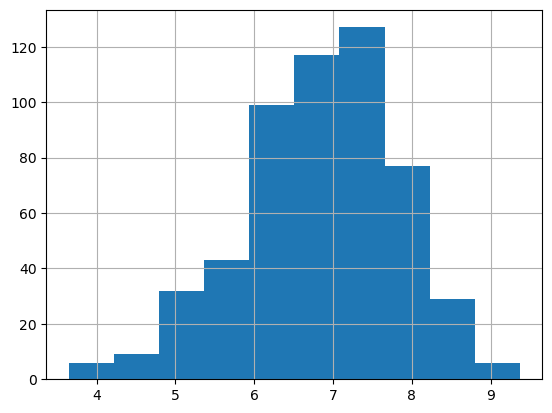

In [25]:
chosen.affinity.hist()

In [26]:
from generation_utils import get_LAS_distance_constraint_mask, get_info_pred_distance, write_with_new_coords


In [27]:
# pick one with affinity greater than 7.
chosen = info_mini.loc[info_mini.groupby(['protein_name', 'smiles'],sort=False)['affinity'].agg('idxmax')].reset_index()
chosen = chosen.query("affinity > 9").reset_index(drop=True)
line = chosen.iloc[1]
idx = line['index']


In [28]:
print('line: ', line, '\n idx: ', idx)

line:  index                                                           48
protein_name                                                  3ZXZ
compound_name                                                     
smiles           C1(C(C(C)C)N(CC2=CC=CO2)CC2=CC3C(=C(C)C=CC=3)N...
pocket_name                                         protein_center
pocket_com                                     15.481,78.55,10.586
affinity                                                  9.368468
Name: 1, dtype: object 
 idx:  48


In [29]:
chosen

,index,protein_name,compound_name,smiles,pocket_name,pocket_com,affinity
0,30,3ZXZ,,C1(SC=C(C2C=CC=C(C=2)N(=O)=O)N=1)NC(=O)C=CC1=C...,protein_center,"15.481,78.55,10.586",9.198954
1,48,3ZXZ,,C1(C(C(C)C)N(CC2=CC=CO2)CC2=CC3C(=C(C)C=CC=3)N...,protein_center,"15.481,78.55,10.586",9.368468


In [36]:
mini_try[idx:idx+1][0]

HeteroData(
  dis_map=[5544],
  node_xyz=[168, 3],
  coords=[33, 3],
  y=[5544],
  seq=[168],
  compound_pair=[1089, 16],
  protein={
    node_s=[168, 6],
    node_v=[168, 3, 3]
  },
  compound={ x=[33, 56] },
  (protein, p2p, protein)={
    edge_index=[2, 4161],
    edge_s=[4161, 32],
    edge_v=[4161, 1, 3]
  },
  (compound, c2c, compound)={
    edge_index=[2, 72],
    edge_weight=[72],
    edge_attr=[72, 19]
  }
)

In [37]:
one_data = mini_try[idx]
data_with_batch_info = next(iter(DataLoader(mini_try[idx:idx+1], batch_size=1, 
                         follow_batch=['x', 'y', 'compound_pair'], shuffle=False, num_workers=0)))
y_pred, affinity_pred = model(data_with_batch_info)

coords = one_data.coords.to(device)
protein_nodes_xyz = one_data.node_xyz.to(device)
n_compound = coords.shape[0]
n_protein = protein_nodes_xyz.shape[0]
y_pred = y_pred.reshape(n_protein, n_compound).to(device).detach()
y = one_data.dis_map.reshape(n_protein, n_compound).to(device)
compound_pair_dis_constraint = torch.cdist(coords, coords)

In [38]:
smiles = line['smiles']
print(smiles)

C1(C(C(C)C)N(CC2=CC=CO2)CC2=CC3C(=C(C)C=CC=3)NC2=O)=NN=NN1C(C)(C)C


In [39]:
mol = Chem.MolFromSmiles(smiles)
mol.Compute2DCoords()
LAS_distance_constraint_mask = get_LAS_distance_constraint_mask(mol).bool()

In [41]:
chosen_info = get_info_pred_distance(coords, y_pred, protein_nodes_xyz, compound_pair_dis_constraint, 
                              LAS_distance_constraint_mask=LAS_distance_constraint_mask,
                              n_repeat=1, show_progress=False)

In [42]:
chosen_info

,repeat,rmsd,loss,coords
0,0,86.821625,2683.349121,"[[26.3994, 83.02271, 4.1265006], [26.461185, 8..."


In [44]:
new_coords = chosen_info.sort_values("loss")['coords'].iloc[0].astype(np.double)
new_coords

array([[26.39940071, 83.02271271,  4.12650061],
       [26.46118546, 84.20759583,  3.26819062],
       [26.80811501, 83.99140167,  1.75630832],
       [25.73953819, 84.19969177,  0.74874777],
       [24.26147652, 84.01294708,  1.17117512],
       [24.27444839, 85.58414459,  2.07344699],
       [22.80819511, 85.05859375,  2.00607419],
       [22.20603752, 84.86125946,  3.40974355],
       [20.76871872, 84.44417572,  3.51491451],
       [19.86489487, 84.90786743,  4.57274055],
       [18.37797737, 84.74586487,  4.53427601],
       [17.88718224, 83.58028412,  3.5690589 ],
       [16.97315025, 83.02701569, -1.05461371],
       [17.72415924, 82.39987946, -2.34311652],
       [19.15843582, 82.52580261, -1.87686586],
       [19.07336426, 82.67671967, -0.35581687],
       [17.89111519, 81.63816833,  3.98576665],
       [17.82991791, 82.72317505,  5.0145421 ],
       [16.74136734, 83.4278183 ,  5.77836514],
       [17.02000809, 84.85614014,  5.87290239],
       [17.17098236, 83.88796997,  6.999

In [46]:

new_coords[0]

array([26.39940071, 83.02271271,  4.12650061])